# What is ChatGPT Doing? 

## Using GPT2

* https://writings.stephenwolfram.com/2023/02/what-is-chatgpt-doing-and-why-does-it-work/

### Setup

In [1]:
import torch
from torch.nn.functional import cosine_similarity
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

cache_dir='/Commjhub/HF_cache'

In [ ]:
def plot_embedding(data, ax=None):
    matrix = torch.reshape(data, (12,64)).detach().numpy()

    if ax:
        sns.heatmap(matrix, center=0, cmap='Oranges', ax=ax, 
                    cbar=False,
                    xticklabels=False, yticklabels=False)
    else:
        sns.heatmap(matrix, center=0, cmap='Oranges')

In [ ]:
gpt2 = AutoModelForCausalLM.from_pretrained("gpt2", cache_dir=cache_dir,
                                            return_dict_in_generate=True)

tokenizer = AutoTokenizer.from_pretrained("gpt2", cache_dir=cache_dir)
tokenizer.pad_token_id = tokenizer.eos_token_id


### Tokenization

In [ ]:
text = "Once upon a time there was a lonely LLM. One day a new one called ChatGPT come along"

In [ ]:
tokens_ws = text.split()

tokens_ws[:5]

In [40]:
len(tokens_ws)

18

In [41]:
print(tokens_ws)

['Once', 'upon', 'a', 'time', 'there', 'was', 'a', 'lonely', 'LLM.', 'One', 'day', 'a', 'new', 'one', 'called', 'ChatGPT', 'come', 'along']


In [39]:
tokens_gpt = tokenizer.encode(text)
len(tokens_gpt)

2

In [38]:
for tid in tokens_gpt:
    token_str = tokenizer.decode(tid)
    print(f"{ tid: <10}|{ token_str }|")

83        |t|
30915     |ruck|


### Predicting the next token

In [10]:
print(f'Input sequence:\n\n\t{text}')

Input sequence:

	Once upon a time there was a lonely LLM. One day a new one called ChatGPT come along


In [11]:
inputs = tokenizer(text, return_tensors="pt")


print(f"Tokenized input data:\n\n\tids: {inputs['input_ids']}\n\n\tattention_mask: {inputs['attention_mask']}")

Tokenized input data:

	ids: tensor([[ 7454,  2402,   257,   640,   612,   373,   257, 21757, 27140,    44,
            13,  1881,  1110,   257,   649,   530,  1444, 24101,    38, 11571,
          1282,  1863]])

	attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [12]:
with torch.no_grad():
  logits = gpt2(**inputs).logits[:, -1, :]
print("All logits for the next token:\n")
print(logits)
print(logits.shape)

All logits for the next token:

tensor([[ -87.3257,  -90.6228,  -97.0934,  ..., -102.1836,  -99.2723,
          -92.1162]])
torch.Size([1, 50257])


In [13]:
pred_id = torch.argmax(logits).item()
print("\nPredicted token ID of next word: ")
print(pred_id)

pred_word = tokenizer.decode(pred_id)
print("\nPredicted next word for sequence: ")
print(pred_word)



Predicted token ID of next word: 
290

Predicted next word for sequence: 
 and


#### Show the top 5 possible completions

In [14]:
for rank, wid in enumerate(torch.argsort(logits, descending=True)[0][:5],1):
    print(f'{rank} {wid.item(): 8} |{tokenizer.decode(wid)}|')

1      290 | and|
2       13 |.|
3       11 |,|
4      284 | to|
5      351 | with|


### The example from Wolfram article

In [15]:
wolfram = "The best thing about AI is its ability to"

In [16]:

encoded_text = tokenizer(wolfram, return_tensors="pt")

#1. step to get the logits of the next token
with torch.inference_mode():
  outputs = gpt2(**encoded_text)

next_token_logits = outputs.logits[0, -1, :]

print(f"Output from final layer is {next_token_logits.shape} items (all items in vocabulary)")

# 2. step to convert the logits to probabilities
next_token_probs = torch.softmax(next_token_logits, -1)
print(f"\nProbabilities for each vocabulary item occurring next:\n\t{next_token_probs[:10]} ...etc..\n")

# 3. step to get the top 5
topk_next_tokens= torch.topk(next_token_probs, 5)

for idx, prob in zip(topk_next_tokens.indices, topk_next_tokens.values):
    print(f"{tokenizer.decode(idx): <20}{prob:.1%}")

Output from final layer is torch.Size([50257]) items (all items in vocabulary)

Probabilities for each vocabulary item occurring next:
	tensor([1.4932e-06, 1.6340e-06, 5.9778e-09, 7.3276e-09, 2.0416e-07, 8.2873e-08,
        9.7235e-07, 2.7717e-07, 1.1047e-06, 1.4871e-07]) ...etc..

 learn              4.5%
 predict            3.5%
 make               3.2%
 understand         3.1%
 do                 2.9%


### Continue generating text

In [17]:
inputs = tokenizer(wolfram, return_tensors="pt")

In [18]:
outputs = gpt2.generate(**inputs, 
                         max_new_tokens=15, 
                         return_dict_in_generate=True, 
                         output_scores=True,
                         temperature=0.7,
                         do_sample=True,
                         top_k=50,
                         top_p=0.95
                        )


transition_scores = gpt2.compute_transition_scores(
    outputs.sequences, outputs.scores, normalize_logits=True
)
# input_length is the length of the input prompt for decoder-only models, like the GPT family, and 1 for
# encoder-decoder models, like BART or T5.
input_length = 1 if gpt2.config.is_encoder_decoder else inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]


print(wolfram, '\n...')
for tok, score in zip(generated_tokens[0], transition_scores[0]):
    # | token | token string | logits | probability
    tok_str = re.sub('\s+', ' ', tokenizer.decode(tok))
    print(f"| {tok:5d} | {tok_str: <14} | {score.numpy():6.3f} | {np.exp(score.numpy()):.2%}")



<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1571351/3672498996.py:24: SyntaxWarning: invalid escape sequence '\s'
  tok_str = re.sub('\s+', ' ', tokenizer.decode(tok))
/opt/jupyterhub/share/jupyter/venv/python3-12_comm4190/lib/python3.12/site-packages/transformers/generation/utils.py:1528: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The best thing about AI is its ability to 
...
|  2251 |  create        | -3.301 | 3.69%
|  3748 |  unique        | -4.701 | 0.91%
|    11 | ,              | -1.392 | 24.85%
| 13206 |  compelling    | -3.641 | 2.62%
|  6461 |  experiences   | -1.575 | 20.70%
|    13 | .              | -0.568 | 56.68%
|   775 |  We            | -2.248 | 10.56%
|   389 |  are           | -2.934 | 5.32%
|  1262 |  using         | -4.529 | 1.08%
|  9552 |  AI            | -0.815 | 44.28%
|   284 |  to            | -0.094 | 91.01%
|  1037 |  help          | -2.100 | 12.25%
|   514 |  us            | -0.183 | 83.32%
|  1064 |  find          | -4.394 | 1.23%
|   262 |  the           | -1.106 | 33.09%


### Word embeddings

In [19]:
inputs = tokenizer(["cat dog chair"], return_tensors="pt")
embeds = gpt2.transformer.wte.weight[inputs['input_ids'], :]

#### Embedding values for `cat`

* This how GPT2 represents the token `cat` in 768 dimensional space!

In [20]:
embeds[0,0,:]

tensor([-0.0164, -0.0934,  0.2425,  0.1398,  0.0388, -0.2592, -0.2724, -0.1625,
         0.1683,  0.0829,  0.0136, -0.2788,  0.1493,  0.1408,  0.0557, -0.3691,
         0.2200, -0.0428,  0.2206,  0.0865,  0.1237, -0.1499,  0.1446, -0.1150,
        -0.1425, -0.0715, -0.0526,  0.1550, -0.0678, -0.2059,  0.2065, -0.0297,
         0.0834, -0.0483,  0.1207,  0.1975, -0.3193,  0.0124,  0.1067, -0.0473,
        -0.3037,  0.1139,  0.0949, -0.2175,  0.0796, -0.0941, -0.0394, -0.0704,
         0.2033, -0.1555,  0.2928, -0.0770,  0.0787,  0.1214,  0.1528, -0.1464,
         0.4247,  0.1921, -0.0415, -0.0850, -0.2787,  0.0656, -0.2026,  0.1856,
         0.1353, -0.0820, -0.0639,  0.0701,  0.1680,  0.0597,  0.3265, -0.1100,
         0.1056,  0.1845, -0.1156,  0.0054,  0.0663,  0.1842, -0.1069,  0.0491,
        -0.0853, -0.2519,  0.0031,  0.1805,  0.1505,  0.0442, -0.2427,  0.1104,
         0.0970,  0.1123, -0.1519, -0.1444,  0.2323, -0.0241, -0.0677,  0.1157,
        -0.2668, -0.1229,  0.1120,  0.06

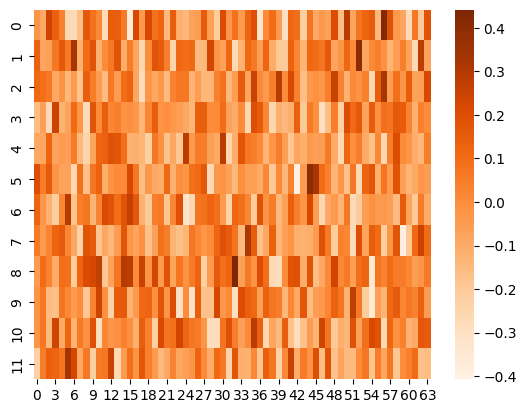

In [21]:
plot_embedding(embeds[0,0,:])

In [22]:
inputs

{'input_ids': tensor([[9246, 3290, 5118]]), 'attention_mask': tensor([[1, 1, 1]])}

In [23]:
inputs['input_ids']

tensor([[9246, 3290, 5118]])

In [24]:
for i in inputs['input_ids'][0]:
    print(tokenizer.decode(i))

cat
 dog
 chair


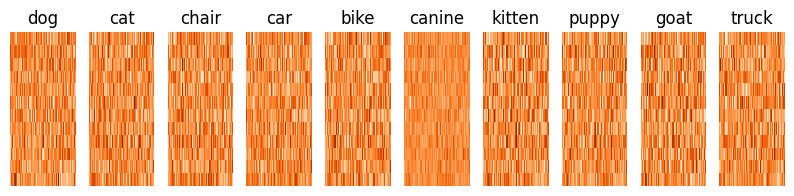

In [25]:
tokens = 'dog cat chair car bike canine kitten puppy goat truck'

#tokens = 'bank river dollar finance water plane wings invest fly grass'

inputs = tokenizer([tokens], return_tensors="pt")

dim = inputs['input_ids'][0].shape[0]
embeds = gpt2.transformer.wte.weight[inputs['input_ids'], :]

fig, ax = plt.subplots(1,dim, figsize=(dim,2))
for idx, token in enumerate(tokens.split()):
    plot_embedding(embeds[0,idx,:], ax=ax[idx])
    ax[idx].set_title(token)

In [26]:
input = embeds[0,:,:]

# Expand dimensions for cosine similarity calculation
input1 = input.unsqueeze(1)  
input2 = input.unsqueeze(0)  

# Calculate cosine similarity
cos_sim = cosine_similarity(input1, input2, dim=2).detach().numpy()

In [27]:
sim_df = pd.DataFrame(cos_sim, index=tokens.split(), columns=tokens.split())
sim_df

,dog,cat,chair,car,bike,canine,kitten,puppy,goat,truck
dog,1.000000,0.343030,0.231451,0.238023,0.304446,0.449869,0.364344,0.472860,0.317302,0.244600
cat,0.343030,1.000000,0.255987,0.381478,0.329638,0.408961,0.501223,0.390975,0.422638,0.268798
chair,0.231451,0.255987,1.000000,0.309766,0.339372,0.237139,0.260853,0.281525,0.245138,0.312186
car,0.238023,0.381478,0.309766,1.000000,0.529137,0.304175,0.285196,0.280986,0.274918,0.539535
bike,0.304446,0.329638,0.339372,0.529137,1.000000,0.319559,0.355173,0.385304,0.381817,0.475775
canine,0.449869,0.408961,0.237139,0.304175,0.319559,1.000000,0.479932,0.561576,0.441975,0.301722
kitten,0.364344,0.501223,0.260853,0.285196,0.355173,0.479932,1.000000,0.618093,0.470098,0.304847
puppy,0.472860,0.390975,0.281525,0.280986,0.385304,0.561576,0.618093,1.000000,0.434561,0.347656
goat,0.317302,0.422638,0.245138,0.274918,0.381817,0.441975,0.470098,0.434561,1.000000,0.421468
truck,0.244600,0.268798,0.312186,0.539535,0.475775,0.301722,0.304847,0.347656,0.421468,1.000000


In [28]:
matrix = embeds[0,:,:].detach().numpy()

In [29]:
matrix.shape

(10, 768)

In [30]:
tsne = TSNE(n_components=2, perplexity=3, 
            random_state=42, init='random', 
            learning_rate=120)
vis_dims = tsne.fit_transform(matrix)


In [31]:
x = vis_dims[:, 0]
y = vis_dims[:, 1]

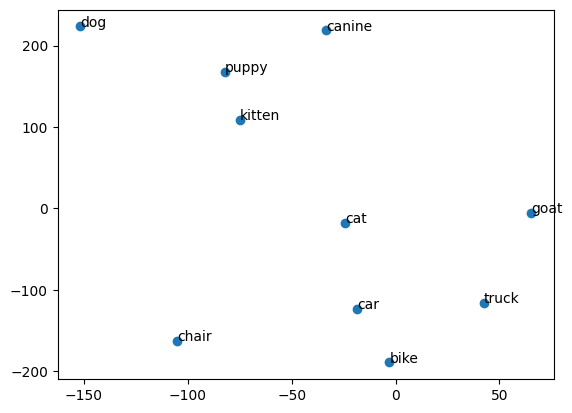

In [32]:
plt.scatter(x,y)
for x1, y1, text in zip(x,y,tokens.split()):
    plt.annotate(text, (x1, y1))

In [33]:
tsne = TSNE(n_components=3, perplexity=6, 
            random_state=42, init='random', 
            learning_rate=120)
vis_dims = tsne.fit_transform(matrix)

x = vis_dims[:, 0]
y = vis_dims[:, 1]
z = vis_dims[:, 2]

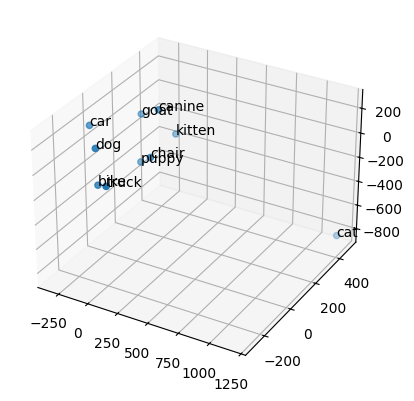

In [34]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
for x1, y1, z1, text in zip(x,y,z,tokens.split()):
    ax.text(x1,y1,z1, text)

### Neural networks

* Some demos
  - https://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html
  - https://huggingface.co/spaces/jph00/pets